In [1]:
import gym
import pandas as pd 
import statistics
import matplotlib.pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import numpy as np
import random
import os

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from datetime import timedelta


from stable_baselines3 import A2C
from stable_baselines3 import SAC

In [2]:
class ShowerEnv(Env):
    def __init__(self, target_temp):
        super(ShowerEnv, self).__init__()

        self.step_counter = 0
        self.reset_counter = 0
    # Building settings1
        self.conditioned_floor_area = 16
        self.heat_mass_capacity = 165000 * self.conditioned_floor_area
        self.heat_transmission = 200
        self.time_step_size = timedelta(minutes=10) # How many minutes into future each step.


    # Starting and target temperature.
        self.current_temperature = 26
        self.target_temperature = target_temp

    # Action space with 1 variable that can vary between 0 and 1000 and stands for how much power we want to send to heating system.
        self.action_space = Box(low=-1000, high=1000, shape=(1,), dtype=np.float32)
        high = np.array([0,100])
        self.observation_space = Box(low=-high, high=high, dtype=np.float32)

    def rescale_power(self, power):
        p = power * 5000
        return p
  
    def step(self, action):
    
    
        self.step_counter += 1

        power = min(max(self.rescale_power(action[0]), 0), 10000)
        self.current_temperature = self.state[0]
    
  
    
        dt_by_cm = self.time_step_size.total_seconds() / self.heat_mass_capacity

        self.next_temperature = (self.current_temperature * (1 - dt_by_cm * self.heat_transmission) + dt_by_cm * (power + self.heat_transmission ))

  
        done = bool(self.step_counter > 10000) #BYT TILL 1000 om det inte funkar igen.....
        self.state = np.array([self.next_temperature, self.target_temperature ])
    
    # ( )² sicne it would make the network prefer small changes. If it does a big step and it's wrong it gets super big pentalty. 
        reward = -(self.next_temperature - self.target_temperature)**2
   
    
    
        return self.state, reward, done, {}
  
    def reset(self):
        self.step_counter = 0
        self.state = np.array([26]) #self.current_temperature = 26
        #self.state = np.array([16])
        self.reset_counter += 1
        if self.reset_counter == 6:
            self.reset_counter = 0
        return self.state

In [3]:
env = DummyVecEnv([lambda: ShowerEnv(5)])

# PID Controller

In [74]:
from simple_pid import PID

target_temp = 5

v = ShowerEnv(target_temp)

v.reset()

stable = False

Kp = 1

Ki = 2

Kd = 0.05

Integrator_state = 0

Derivator_state = 0

temperaturesPID = []
stepsPID = []
rewardPID = []
current_state = [v.current_temperature]

while not stable:

    
    err = current_state[0] - target_temp

    Pvalue = Kp * err

    Dvalue = Kd * (err - Derivator_state)

    Derivator_state = err

    Integrator_state = Integrator_state + 0.1*err

    Ivalue = Ki * Integrator_state

    PID_control_input = [-1*(Pvalue + Ivalue + Dvalue)]

    current_state,reward,done,_ = v.step(PID_control_input)
    
    rewardPID.append(reward)
    
    temperaturesPID.append(current_state[0])
    
    stepsPID.append(v.step_counter) 
    
    if v.step_counter>3000:
        stable=True



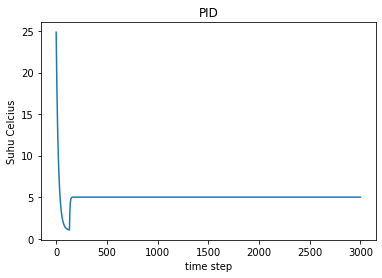

In [75]:
plt.subplot(1, 1, 1)
plt.plot(stepsPID,temperaturesPID)
plt.title("PID")
plt.xlabel("time step")
plt.ylabel("Suhu Celcius")

plt.show()

## Train Model PPO

In [50]:
log_path = os.path.join('Training', 'Logs')

In [51]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path,learning_rate=0.001)

Using cpu device


In [52]:
model.learn(total_timesteps=100000)

Logging to Training\Logs\PPO_103
-----------------------------
| time/              |      |
|    fps             | 1172 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 910         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017487641 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 2.97e-05    |
|    learning_rate        | 0.001       |
|    loss                 | 2.67e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0173     |
|    std                  | 0.941       |
|    value_loss           | 3.62e+05    |
-

-----------------------------------------
| time/                   |             |
|    fps                  | 843         |
|    iterations           | 12          |
|    time_elapsed         | 29          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.015197985 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | -0.0161     |
|    learning_rate        | 0.001       |
|    loss                 | 0.727       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0104     |
|    std                  | 0.68        |
|    value_loss           | 3.59        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 835          |
|    iterations           | 13           |
|    time_elapsed         | 31

----------------------------------------
| time/                   |            |
|    fps                  | 828        |
|    iterations           | 23         |
|    time_elapsed         | 56         |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.02462881 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | -0.00989   |
|    learning_rate        | 0.001      |
|    loss                 | 0.0917     |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.00496   |
|    std                  | 0.344      |
|    value_loss           | 0.266      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 829         |
|    iterations           | 24          |
|    time_elapsed         | 59          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 835         |
|    iterations           | 34          |
|    time_elapsed         | 83          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.035585716 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.461       |
|    explained_variance   | 0.00158     |
|    learning_rate        | 0.001       |
|    loss                 | 0.00288     |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.146       |
|    value_loss           | 0.0183      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 835         |
|    iterations           | 35          |
|    time_elapsed         | 85    

--------------------------------------
| time/                   |          |
|    fps                  | 834      |
|    iterations           | 45       |
|    time_elapsed         | 110      |
|    total_timesteps      | 92160    |
| train/                  |          |
|    approx_kl            | 0.582896 |
|    clip_fraction        | 0.37     |
|    clip_range           | 0.2      |
|    entropy_loss         | 1.33     |
|    explained_variance   | 0.181    |
|    learning_rate        | 0.001    |
|    loss                 | 617      |
|    n_updates            | 440      |
|    policy_gradient_loss | 0.017    |
|    std                  | 0.0632   |
|    value_loss           | 1.1e+04  |
--------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 834         |
|    iterations           | 46          |
|    time_elapsed         | 112         |
|    total_timesteps      | 94208       |
| train

In [53]:
model.save('PPO')

# Evaluate PPO

In [54]:
model = PPO.load("PPO")

In [55]:
evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\Adam\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


(-3390.8414388797246, 0.0)

#  Training A2C

In [56]:
log_pathA2C = os.path.join('Training', 'Logs')

In [57]:
modelA2C = A2C("MlpPolicy", env,tensorboard_log=log_pathA2C, verbose=1,learning_rate=0.001)

Using cpu device


In [58]:
modelA2C.learn(total_timesteps=100000)

Logging to Training\Logs\A2C_30
-------------------------------------
| time/                 |           |
|    fps                | 668       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.48     |
|    explained_variance | -2.72e-05 |
|    learning_rate      | 0.001     |
|    n_updates          | 99        |
|    policy_loss        | -577      |
|    std                | 1.06      |
|    value_loss         | 1.2e+05   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 689       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.47     |
|    explained_variance | -1.91e-06 |
|    learning_rate      | 0.001     |
|    n_updates    

------------------------------------
| time/                 |          |
|    fps                | 737      |
|    iterations         | 1600     |
|    time_elapsed       | 10       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -1.21    |
|    explained_variance | 0.0111   |
|    learning_rate      | 0.001    |
|    n_updates          | 1599     |
|    policy_loss        | 0.0827   |
|    std                | 0.809    |
|    value_loss         | 0.0377   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 738      |
|    iterations         | 1700     |
|    time_elapsed       | 11       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -1.17    |
|    explained_variance | 0.237    |
|    learning_rate      | 0.001    |
|    n_updates          | 1699     |
|    policy_loss        | -0.00139 |
|

------------------------------------
| time/                 |          |
|    fps                | 737      |
|    iterations         | 3100     |
|    time_elapsed       | 21       |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -0.679   |
|    explained_variance | -0.336   |
|    learning_rate      | 0.001    |
|    n_updates          | 3099     |
|    policy_loss        | 0.00733  |
|    std                | 0.477    |
|    value_loss         | 0.000935 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 737      |
|    iterations         | 3200     |
|    time_elapsed       | 21       |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -0.651   |
|    explained_variance | 0.274    |
|    learning_rate      | 0.001    |
|    n_updates          | 3199     |
|    policy_loss        | 0.0107   |
|

------------------------------------
| time/                 |          |
|    fps                | 739      |
|    iterations         | 4600     |
|    time_elapsed       | 31       |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -0.141   |
|    explained_variance | 0.0276   |
|    learning_rate      | 0.001    |
|    n_updates          | 4599     |
|    policy_loss        | -0.0136  |
|    std                | 0.279    |
|    value_loss         | 0.00587  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 738      |
|    iterations         | 4700     |
|    time_elapsed       | 31       |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -0.0947  |
|    explained_variance | -0.00319 |
|    learning_rate      | 0.001    |
|    n_updates          | 4699     |
|    policy_loss        | 0.00159  |
|

------------------------------------
| time/                 |          |
|    fps                | 740      |
|    iterations         | 6100     |
|    time_elapsed       | 41       |
|    total_timesteps    | 30500    |
| train/                |          |
|    entropy_loss       | 0.57     |
|    explained_variance | 0.0151   |
|    learning_rate      | 0.001    |
|    n_updates          | 6099     |
|    policy_loss        | 0.0144   |
|    std                | 0.137    |
|    value_loss         | 0.00218  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 740      |
|    iterations         | 6200     |
|    time_elapsed       | 41       |
|    total_timesteps    | 31000    |
| train/                |          |
|    entropy_loss       | 0.611    |
|    explained_variance | -0.00351 |
|    learning_rate      | 0.001    |
|    n_updates          | 6199     |
|    policy_loss        | -0.0232  |
|

------------------------------------
| time/                 |          |
|    fps                | 735      |
|    iterations         | 7600     |
|    time_elapsed       | 51       |
|    total_timesteps    | 38000    |
| train/                |          |
|    entropy_loss       | 1.26     |
|    explained_variance | -0.00561 |
|    learning_rate      | 0.001    |
|    n_updates          | 7599     |
|    policy_loss        | 0.015    |
|    std                | 0.0686   |
|    value_loss         | 0.00264  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 735      |
|    iterations         | 7700     |
|    time_elapsed       | 52       |
|    total_timesteps    | 38500    |
| train/                |          |
|    entropy_loss       | 1.31     |
|    explained_variance | -0.0074  |
|    learning_rate      | 0.001    |
|    n_updates          | 7699     |
|    policy_loss        | -0.0148  |
|

------------------------------------
| time/                 |          |
|    fps                | 727      |
|    iterations         | 9100     |
|    time_elapsed       | 62       |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | 1.25     |
|    explained_variance | 0        |
|    learning_rate      | 0.001    |
|    n_updates          | 9099     |
|    policy_loss        | 7.1e+03  |
|    std                | 0.0692   |
|    value_loss         | 4.14e+07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 727      |
|    iterations         | 9200     |
|    time_elapsed       | 63       |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | 1.21     |
|    explained_variance | 0        |
|    learning_rate      | 0.001    |
|    n_updates          | 9199     |
|    policy_loss        | 22       |
|

------------------------------------
| time/                 |          |
|    fps                | 725      |
|    iterations         | 10600    |
|    time_elapsed       | 73       |
|    total_timesteps    | 53000    |
| train/                |          |
|    entropy_loss       | 1.57     |
|    explained_variance | 0.00195  |
|    learning_rate      | 0.001    |
|    n_updates          | 10599    |
|    policy_loss        | -0.00229 |
|    std                | 0.0504   |
|    value_loss         | 4e-06    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 10700    |
|    time_elapsed       | 73       |
|    total_timesteps    | 53500    |
| train/                |          |
|    entropy_loss       | 1.62     |
|    explained_variance | 0.0163   |
|    learning_rate      | 0.001    |
|    n_updates          | 10699    |
|    policy_loss        | -0.00447 |
|

-------------------------------------
| time/                 |           |
|    fps                | 724       |
|    iterations         | 12100     |
|    time_elapsed       | 83        |
|    total_timesteps    | 60500     |
| train/                |           |
|    entropy_loss       | 2         |
|    explained_variance | -8.21e-05 |
|    learning_rate      | 0.001     |
|    n_updates          | 12099     |
|    policy_loss        | 86.1      |
|    std                | 0.0326    |
|    value_loss         | 2.26e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 12200    |
|    time_elapsed       | 84       |
|    total_timesteps    | 61000    |
| train/                |          |
|    entropy_loss       | 2.01     |
|    explained_variance | 0.13     |
|    learning_rate      | 0.001    |
|    n_updates          | 12199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 725      |
|    iterations         | 13600    |
|    time_elapsed       | 93       |
|    total_timesteps    | 68000    |
| train/                |          |
|    entropy_loss       | 2.19     |
|    explained_variance | -0.459   |
|    learning_rate      | 0.001    |
|    n_updates          | 13599    |
|    policy_loss        | -0.344   |
|    std                | 0.0271   |
|    value_loss         | 0.035    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 725      |
|    iterations         | 13700    |
|    time_elapsed       | 94       |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | 2.19     |
|    explained_variance | 0.279    |
|    learning_rate      | 0.001    |
|    n_updates          | 13699    |
|    policy_loss        | -1.1     |
|

-------------------------------------
| time/                 |           |
|    fps                | 724       |
|    iterations         | 15100     |
|    time_elapsed       | 104       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | 2.28      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.001     |
|    n_updates          | 15099     |
|    policy_loss        | 107       |
|    std                | 0.0247    |
|    value_loss         | 2.41e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 15200    |
|    time_elapsed       | 104      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | 2.27     |
|    explained_variance | 0        |
|    learning_rate      | 0.001    |
|    n_updates          | 15199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 16600    |
|    time_elapsed       | 114      |
|    total_timesteps    | 83000    |
| train/                |          |
|    entropy_loss       | 2.25     |
|    explained_variance | 0.0357   |
|    learning_rate      | 0.001    |
|    n_updates          | 16599    |
|    policy_loss        | -3.57    |
|    std                | 0.0255   |
|    value_loss         | 2.65     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 16700    |
|    time_elapsed       | 115      |
|    total_timesteps    | 83500    |
| train/                |          |
|    entropy_loss       | 2.26     |
|    explained_variance | -3.06    |
|    learning_rate      | 0.001    |
|    n_updates          | 16699    |
|    policy_loss        | 0.0191   |
|

------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 18100    |
|    time_elapsed       | 124      |
|    total_timesteps    | 90500    |
| train/                |          |
|    entropy_loss       | 2.28     |
|    explained_variance | -0.116   |
|    learning_rate      | 0.001    |
|    n_updates          | 18099    |
|    policy_loss        | -0.0636  |
|    std                | 0.0246   |
|    value_loss         | 0.000745 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 724      |
|    iterations         | 18200    |
|    time_elapsed       | 125      |
|    total_timesteps    | 91000    |
| train/                |          |
|    entropy_loss       | 2.31     |
|    explained_variance | 0.347    |
|    learning_rate      | 0.001    |
|    n_updates          | 18199    |
|    policy_loss        | 0.0242   |
|

------------------------------------
| time/                 |          |
|    fps                | 726      |
|    iterations         | 19600    |
|    time_elapsed       | 134      |
|    total_timesteps    | 98000    |
| train/                |          |
|    entropy_loss       | 2.48     |
|    explained_variance | 0.0871   |
|    learning_rate      | 0.001    |
|    n_updates          | 19599    |
|    policy_loss        | -0.0205  |
|    std                | 0.0203   |
|    value_loss         | 7.47e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 726      |
|    iterations         | 19700    |
|    time_elapsed       | 135      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | 2.5      |
|    explained_variance | 0.0906   |
|    learning_rate      | 0.001    |
|    n_updates          | 19699    |
|    policy_loss        | 0.0159   |
|

In [59]:
modelA2C.save("A2C")

#  Evaluate A2C

In [60]:
modelA2C= A2C.load("A2C")

In [61]:
evaluate_policy(modelA2C, env, n_eval_episodes=10)

(-3350.6615689600585, 0.0)

# Training SAC

In [62]:
log_pathSAC = os.path.join('Training', 'Logs')

In [63]:
modelSAC = SAC("MlpPolicy", env,tensorboard_log=log_pathA2C, verbose=1,learning_rate=0.001)

Using cpu device


In [64]:
modelSAC.learn(total_timesteps=100000)

Logging to Training\Logs\SAC_19
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 956      |
|    total_timesteps | 40004    |
| train/             |          |
|    actor_loss      | 88.2     |
|    critic_loss     | 81.5     |
|    ent_coef        | 0.15     |
|    ent_coef_loss   | 0.257    |
|    learning_rate   | 0.001    |
|    n_updates       | 39903    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 40       |
|    time_elapsed    | 1958     |
|    total_timesteps | 80008    |
| train/             |          |
|    actor_loss      | 61.9     |
|    critic_loss     | 0.808    |
|    ent_coef        | 0.0485   |
|    ent_coef_loss   | 0.0861   |
|    learning_rate   | 0.001    |
|    n_updates       | 79907    |
---------------------------------


In [65]:
modelSAC.save("SAC")

# Evaluate SAC

In [66]:
modelSAC= SAC.load("SAC")

In [67]:
evaluate_policy(modelSAC, env, n_eval_episodes=10)

(-7893.841220797765, 0.0)

## Ploting 

In [68]:
obs = env.reset()

temperatures = []
actions = []
steps = []

step = 0
while True:
    step += 1
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)


    temperatures.append(obs[0][0])
    actions.append(action[0][0]*3000)
    steps.append(step) 
    
    if(step == 3000):
        print('Done')
        break


    

Done


In [69]:
obs = env.reset()

temperaturesA2C = []
actionsA2C = []
stepsA2C = []

step = 0
while True:
    step += 1
    action, _states = modelA2C.predict(obs)
    obs, rewards, dones, info = env.step(action)


    temperaturesA2C.append(obs[0][0])
    actionsA2C.append(action[0][0]*3000)
    stepsA2C.append(step) 
    
    if(step == 3000):
        print('Done')
        break

Done


In [70]:
obs = env.reset()

temperaturesSAC = []
actionsSAC = []
stepsSAC = []

step = 0
while True:
    step += 1
    action, _states = modelSAC.predict(obs)
    obs, rewards, dones, info = env.step(action)


    temperaturesSAC.append(obs[0][0])
    actionsSAC.append(action[0][0]*3000)
    stepsSAC.append(step) 
    
    if(step == 3000):
        print('Done')
        break

Done


In [71]:
temperatures

[24.863636,
 23.778925,
 22.74352,
 21.755178,
 20.811762,
 19.911226,
 19.051624,
 18.231096,
 17.447865,
 16.700235,
 15.986588,
 15.305379,
 14.655135,
 14.034447,
 13.441972,
 12.876428,
 12.33659,
 11.821291,
 11.329413,
 10.859895,
 10.411717,
 9.983912,
 9.575553,
 9.185755,
 8.813675,
 8.4585085,
 8.119485,
 7.795872,
 7.486969,
 7.1921067,
 6.9106474,
 6.6419816,
 6.3855276,
 6.140731,
 5.9070616,
 5.6840134,
 5.4711037,
 5.2678714,
 5.0738773,
 4.924804,
 5.039953,
 4.856319,
 4.9497433,
 4.919676,
 4.999089,
 4.923277,
 4.8966994,
 4.9111385,
 4.928437,
 4.9309835,
 4.98071,
 4.881259,
 4.9434247,
 4.914481,
 4.8530507,
 4.8751974,
 4.999573,
 4.9521046,
 4.914302,
 4.9145713,
 4.948506,
 4.9596167,
 4.9224257,
 5.027409,
 4.8635607,
 4.9637737,
 4.951544,
 4.908421,
 4.940135,
 4.989301,
 4.8623476,
 4.8262277,
 4.9251304,
 4.9294553,
 4.9535995,
 4.924697,
 4.9054956,
 4.9088693,
 4.991308,
 4.8767066,
 4.9872003,
 4.8920164,
 5.0086126,
 4.8790708,
 4.8575025,
 4.9350305,

In [72]:
temperaturesA2C

[24.863636,
 23.778925,
 22.74352,
 21.755178,
 20.811762,
 19.911226,
 19.051624,
 18.231096,
 17.447865,
 16.700235,
 15.986588,
 15.305379,
 14.655135,
 14.034447,
 13.441972,
 12.876428,
 12.33659,
 11.821291,
 11.329413,
 10.859895,
 10.411717,
 9.983912,
 9.575553,
 9.185755,
 8.813675,
 8.4585085,
 8.119485,
 7.795872,
 7.486969,
 7.1921067,
 6.9106474,
 6.6419816,
 6.3855276,
 6.140731,
 5.9070616,
 5.6840134,
 5.4711037,
 5.2678714,
 5.0738773,
 4.979361,
 4.999143,
 5.007497,
 5.0051517,
 5.045648,
 5.015985,
 5.0227447,
 5.0528307,
 5.006442,
 5.0492682,
 5.0292735,
 5.0544477,
 4.996656,
 5.013956,
 5.018931,
 5.041807,
 5.014268,
 5.026396,
 4.9824057,
 5.01667,
 5.008924,
 5.002363,
 5.0321255,
 5.0484443,
 5.0109825,
 5.01195,
 5.044247,
 5.031739,
 4.997566,
 5.026756,
 5.01625,
 5.0109234,
 5.013831,
 5.026462,
 5.03711,
 5.009537,
 4.9893465,
 5.0168405,
 5.0476565,
 5.0072155,
 5.0348287,
 5.004119,
 5.0086765,
 5.02752,
 4.989945,
 5.0407453,
 5.004491,
 5.0385084,


In [73]:
temperaturesSAC

[24.863636,
 23.778925,
 22.74352,
 21.755178,
 20.811762,
 19.911226,
 19.051624,
 18.231096,
 17.447865,
 16.700235,
 15.986588,
 15.305379,
 14.655135,
 14.034447,
 13.441972,
 12.876428,
 12.33659,
 11.821291,
 11.329413,
 10.859895,
 10.411717,
 9.983912,
 9.575553,
 9.185755,
 8.813675,
 8.4585085,
 8.119485,
 7.795872,
 7.486969,
 7.1921067,
 6.9106474,
 6.6419816,
 6.3855276,
 6.140731,
 5.9070616,
 5.6840134,
 5.4711037,
 5.2678714,
 5.0738773,
 4.888701,
 4.711942,
 4.543217,
 4.382162,
 4.2284274,
 4.081681,
 3.9416044,
 6.080622,
 5.8496847,
 5.629245,
 5.4188247,
 5.217969,
 5.0262427,
 4.8432317,
 4.6685395,
 4.5017877,
 4.3426156,
 4.1906786,
 4.0456476,
 3.9072092,
 6.0477905,
 5.8183455,
 5.59933,
 5.3902693,
 5.1907115,
 5.0002246,
 4.8183966,
 4.644833,
 4.479159,
 4.321015,
 4.1700597,
 4.025966,
 3.8884223,
 6.0298576,
 5.8012276,
 5.58299,
 5.3746724,
 5.1758237,
 4.9860134,
 4.804831,
 4.631884,
 4.466799,
 4.309217,
 4.1587977,
 4.0152164,
 3.878161,
 6.0200624,

In [74]:
dict = {'Temperature PPO': temperatures,  'Actions PPO': actions,'Temperature A2C': temperaturesA2C,  'Actions A2C': actionsA2C,'Temperature SAC': temperaturesSAC,  'Actions SAC': actionsSAC}
df = pd.DataFrame(dict)
df

,Temperature PPO,Actions PPO,Temperature A2C,Actions A2C,Temperature SAC,Actions SAC
0,24.863636,-2459.912002,24.863636,-1972.374201,24.863636,-3.000000e+06
1,23.778925,-2748.293102,23.778925,-2157.025158,23.778925,-3.000000e+06
2,22.743521,-2785.197258,22.743521,-2194.566250,22.743521,-3.000000e+06
3,21.755178,-2723.041534,21.755178,-2221.644759,21.755178,-3.000000e+06
4,20.811762,-2833.753824,20.811762,-2303.583562,20.811762,-3.000000e+06
5,19.911226,-2562.560499,19.911226,-2182.587862,19.911226,-3.000000e+06
6,19.051624,-2756.517112,19.051624,-2253.863275,19.051624,-3.000000e+06
7,18.231096,-2763.300240,18.231096,-2294.102848,18.231096,-3.000000e+06
8,17.447865,-2596.024632,17.447865,-2256.416738,17.447865,-3.000000e+06
9,16.700235,-2545.009553,16.700235,-2268.824995,16.700235,-3.000000e+06


In [75]:
meanTempPPO=statistics.mean(temperatures)
meanTempA2C=statistics.mean(temperaturesA2C)
meanTempSAC=statistics.mean(temperaturesSAC)
print("Rata-Rata Temp PPO = ",meanTempPPO)
print("Rata-Rata Temp A2C = ",meanTempA2C)
print("Rata-Rata Temp SAC = ",meanTempSAC)

Rata-Rata Temp PPO =  5.026909
Rata-Rata Temp A2C =  5.110342
Rata-Rata Temp SAC =  5.003957


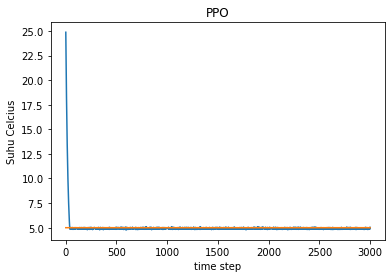

In [76]:
plt.subplot(1, 1, 1)
plt.plot(steps, temperatures)
plt.plot(steps, [5]*len(steps))
plt.title("PPO")
plt.xlabel("time step")
plt.ylabel("Suhu Celcius")

plt.show()

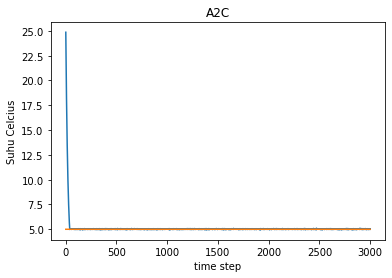

In [77]:
plt.subplot(1, 1, 1)
plt.plot(steps, temperaturesA2C)
plt.plot(steps, [5]*len(stepsA2C))
plt.title("A2C")
plt.xlabel("time step")
plt.ylabel("Suhu Celcius")


plt.show()

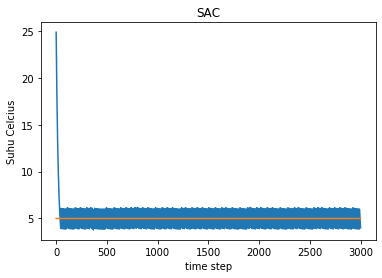

In [78]:
plt.subplot(1, 1, 1)
plt.plot(steps, temperaturesSAC)
plt.plot(steps, [5]*len(stepsSAC))
plt.title("SAC")
plt.xlabel("time step")
plt.ylabel("Suhu Celcius")


plt.show()